## Code is copied from: https://scikit-gstat.readthedocs.io/en/latest/userguide/kriging.html
### Functions as a first idea, to maybe implement this process in Python

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import skgstat as skg
import geopandas as gpd

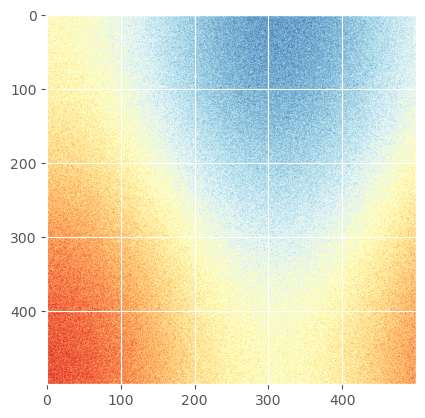

In [ ]:
# apply the function to a meshgrid and add noise
xx, yy = np.mgrid[0:0.5 * np.pi:500j, 0:0.8 * np.pi:500j]

np.random.seed(42)

# generate a regular field
_field = np.sin(xx)**2 + np.cos(yy)**2 + 10

# add noise
np.random.seed(42)

z = _field + np.random.normal(0, 0.15, (500,  500))

plt.imshow(z, cmap='RdYlBu_r')

c:\Users\user\anaconda3\envs\geoscripting\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


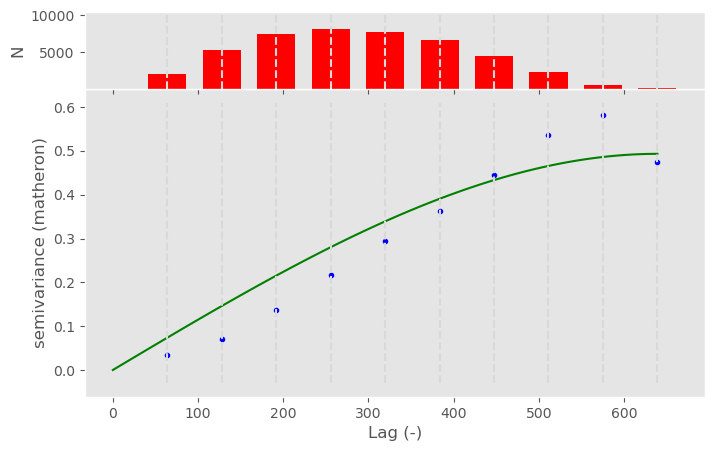

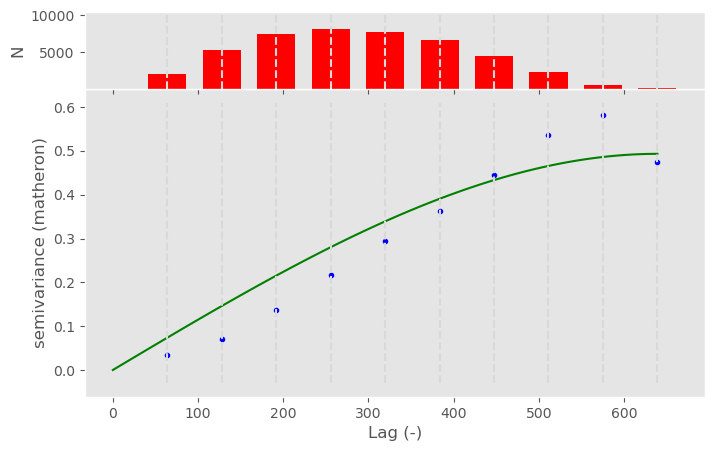

In [7]:

# random coordinates
np.random.seed(42)

coords = np.random.randint(0, 500, (300, 2))

values = np.fromiter((z[c[0], c[1]] for c in coords), dtype=float)

V = skg.Variogram(coords, values)

V.plot()

## Experimental variograms

C:\Users\user\AppData\Local\Temp\ipykernel_8900\1695779257.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


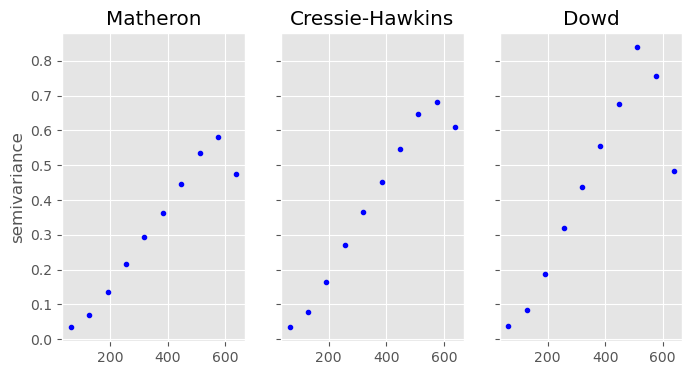

In [8]:
fig, _a = plt.subplots(1, 3, figsize=(8,4), sharey=True)

axes = _a.flatten()

axes[0].plot(V.bins, V.experimental, '.b')

V.estimator = 'cressie'

axes[1].plot(V.bins, V.experimental, '.b')

V.estimator = 'dowd'

axes[2].plot(V.bins, V.experimental, '.b')

axes[0].set_ylabel('semivariance')

axes[0].set_title('Matheron')

axes[1].set_title('Cressie-Hawkins')

axes[2].set_title('Dowd')

fig.show()

## Spherical model

In [9]:
from skgstat import models

# set estimator back
V.estimator = 'matheron'

V.model = 'spherical'

xdata = V.bins

ydata = V.experimental

from scipy.optimize import curve_fit

# initial guess - otherwise lm will not find a range
p0 = [np.mean(xdata), np.mean(ydata), 0]

cof, cov =curve_fit(models.spherical, xdata, ydata, p0=p0)

In [10]:
print("range: %.2f   sill: %.f   nugget: %.2f" % (cof[0], cof[1], cof[2]))

range: 691.51   sill: 1   nugget: -0.10


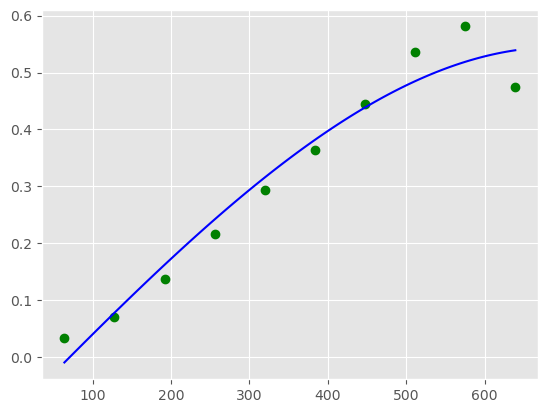

In [11]:
xi =np.linspace(xdata[0], xdata[-1], 100)

yi = [models.spherical(h, *cof) for h in xi]

plt.plot(xdata, ydata, 'og')

plt.plot(xi, yi, '-b');

c:\Users\user\anaconda3\envs\geoscripting\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[639.2949241156227, 0.49327916951059547, 0]
[1132.56434548625, 0.7413661821673165, 0]


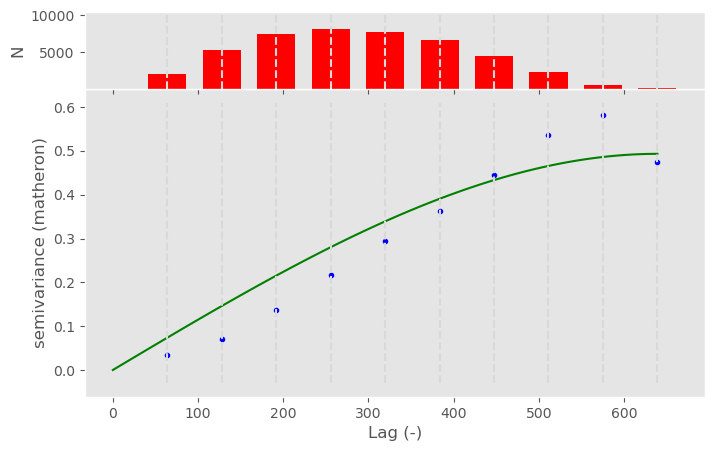

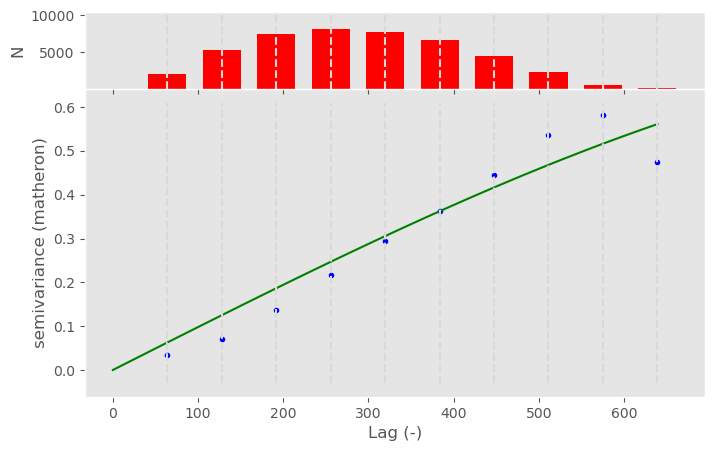

In [12]:
V.fit_method ='trf'

V.plot();

pprint(V.parameters)

V.fit_method ='lm'

V.plot();

pprint(V.parameters)

## Exponential model

c:\Users\user\anaconda3\envs\geoscripting\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


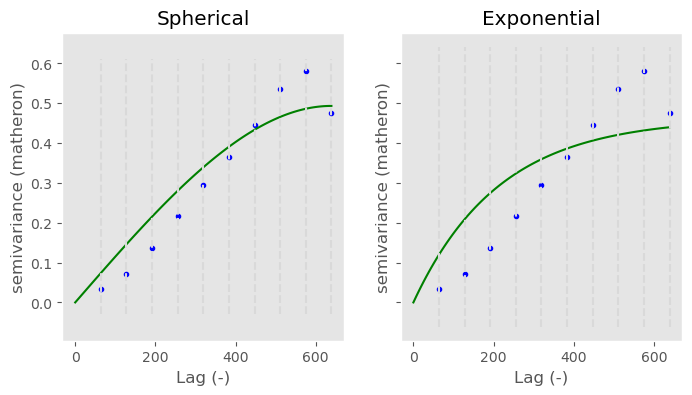

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

axes[0].set_title('Spherical')

axes[1].set_title('Exponential')

V.fit_method = 'trf'

V.plot(axes=axes[0], hist=False)

# switch the model
V.model = 'exponential'

V.plot(axes=axes[1], hist=False);

In [14]:
# spherical
V.model = 'spherical'

rmse_sph = V.rmse

r_sph = V.describe().get('effective_range')

# exponential
V.model = 'exponential'

rmse_exp = V.rmse

r_exp = V.describe().get('effective_range')

print('Spherical   RMSE: %.2f' % rmse_sph)

print('Exponential RMSE: %.2f' % rmse_exp)

Spherical   RMSE: 0.06
Exponential RMSE: 0.10


In [15]:
print('Spherical effective range:    %.1f' % r_sph)

print('Exponential effective range:  %.1f' % r_exp)

Spherical effective range:    639.3
Exponential effective range:  639.3


ImportError: to_gstools: GSTools not installed.

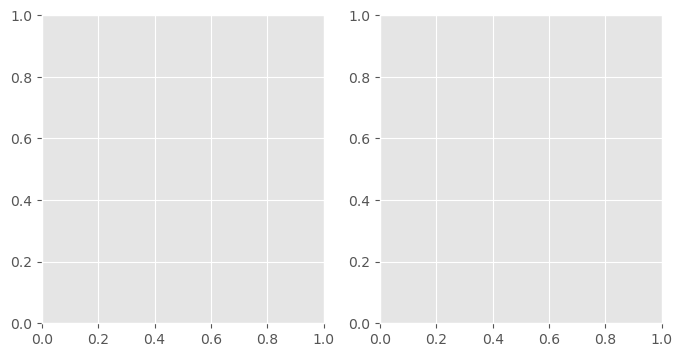

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

V.model = 'spherical'

krige1 = V.to_gs_krige()

V.model = 'exponential'

krige2 = V.to_gs_krige()

# build a grid
x = y = np.arange(0, 500, 5)

# apply
field1, _ = krige1.structured((x, y))

field2, _ = krige2.structured((x, y))

# use the same bounds
vmin = np.min((field1, field2))

vmax = np.max((field1, field2))

# plot
axes[0].set_title('Spherical')

axes[1].set_title('Exponential')

axes[0].imshow(field1, origin='lower', cmap='terrain_r', vmin=vmin, vmax=vmax)

axes[1].imshow(field2, origin='lower', cmap='terrain_r', vmin=vmin, vmax=vmax)

In [17]:
# calculate the differences
diff = np.abs(field2 - field1)

print('Mean difference:     %.1f' % np.mean(diff))

print('3rd quartile diffs.: %.1f' % np.percentile(diff, 75))

print('Max differences:     %.1f' % np.max(diff))

plt.imshow(diff, origin='lower', cmap='hot')

plt.colorbar()

NameError: name 'field2' is not defined

## Try with own data

In [22]:
# Load the GeoPackage file
gdf = gpd.read_file("../data/sensor_data_202407081200_7days.gpkg")

# Display the first few rows
gdf

,entity_id,dateobserved,dateobserved-hourly,description,location,temperature,relativehumidity,dewpoint,atmosphericpressure,solarradiation,precipitation,windspeed,winddirection,geometry
0,hd:DE_Heidelberg_69118_8:WeatherObserved,2023-07-08T12:03:18.358000+00:00,2023-07-08T12:00:00+00:00,Lufft Wetterstation WS601 Köpfel,"{""coordinates"": [8.749880791, 49.420654184], ""...",29.2,39.9,14.2,992.40,NaN,0.0,2.20,291.2,POINT (8.74988 49.42065)
1,hd:DE_Heidelberg_69115_28:WeatherObserved,2023-07-08T12:02:00.292000+00:00,2023-07-08T12:00:00+00:00,MeteoHelix_03_Altstadt_Bismarckplatz,"{""coordinates"": [8.692997438, 49.409958497], ""...",30.3,40.0,NaN,1004.95,630.0,NaN,NaN,NaN,POINT (8.69300 49.40996)
2,hd:DE_Heidelberg_46:WeatherObserved,2023-07-08T12:02:55.192001+00:00,2023-07-08T12:00:00+00:00,MeteoHelixR_21_Boxberg_DAH,"{""coordinates"": [8.703570385, 49.374008928], ""...",28.6,39.4,NaN,990.40,78.0,NaN,NaN,NaN,POINT (8.70357 49.37401)
3,hd:DE_Heidelberg_69117_36:WeatherObserved,2023-07-08T12:05:05.995000+00:00,2023-07-08T12:00:00+00:00,MeteoHelix_11_Weststadt_Christuskirche,"{""coordinates"": [8.685379562, 49.402040105], ""...",31.4,37.2,NaN,1004.70,782.0,NaN,NaN,NaN,POINT (8.68538 49.40204)
4,hd:DE_Heidelberg_69123_3:WeatherObserved,2023-07-08T12:10:00+00:00,2023-07-08T12:00:00+00:00,Wasserwerk Rauschen,"{""coordinates"": [8.623167, 49.42132], ""type"": ...",32.1,34.2,NaN,NaN,NaN,1.5,1.96,324.0,POINT (8.62317 49.42132)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18494,hd:DE_Heidelberg_69115_4:WeatherObserved,2023-07-10T07:40:00+00:00,2023-07-10T08:00:00+00:00,Institutsdach Czernyring,"{""coordinates"": [8.6761, 49.400672], ""type"": ""...",24.7,67.4,NaN,1004.10,NaN,0.1,2.60,342.0,POINT (8.67610 49.40067)
18495,hd:DE_Heidelberg_69115_4:WeatherObserved,2023-07-10T10:00:00+00:00,2023-07-10T10:00:00+00:00,Institutsdach Czernyring,"{""coordinates"": [8.6761, 49.400672], ""type"": ""...",28.6,53.4,NaN,1004.10,NaN,0.1,3.80,306.0,POINT (8.67610 49.40067)
18496,hd:DE_Heidelberg_69115_4:WeatherObserved,2023-07-10T11:10:00+00:00,2023-07-10T11:00:00+00:00,Institutsdach Czernyring,"{""coordinates"": [8.6761, 49.400672], ""type"": ""...",30.1,47.9,NaN,1003.40,NaN,0.1,3.00,269.0,POINT (8.67610 49.40067)
18497,hd:DE_Heidelberg_69115_4:WeatherObserved,2023-07-10T10:50:00+00:00,2023-07-10T11:00:00+00:00,Institutsdach Czernyring,"{""coordinates"": [8.6761, 49.400672], ""type"": ""...",29.4,50.1,NaN,1003.60,NaN,0.1,3.00,280.0,POINT (8.67610 49.40067)


In [24]:
import numpy as np

# Convert geometry to X, Y coordinates
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y

# Define variables for variogram calculation
coords = np.array(list(zip(gdf["x"], gdf["y"])))  # Spatial coordinates
values = gdf["temperature"].values          # The measured variable

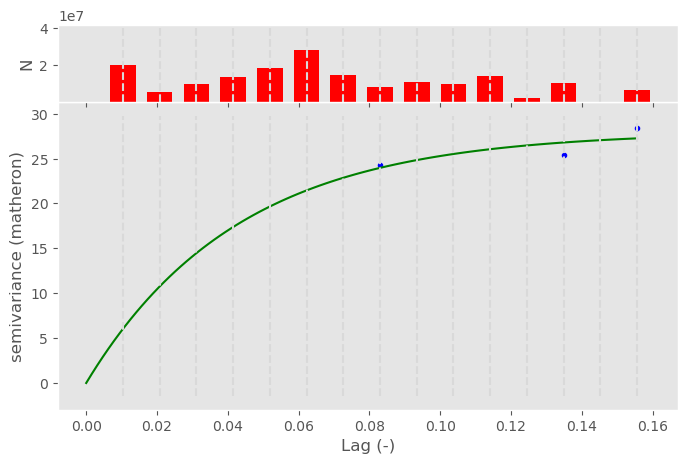

In [31]:
import skgstat as skg
import matplotlib.pyplot as plt

# Create variogram object
V = skg.Variogram(coords, values, model='exponential', n_lags=15)

# Plot the experimental variogram
V.plot()
plt.show()

In [26]:
print("Range:", V.parameters[0])   # Range (distance at which spatial correlation disappears)
print("Sill:", V.parameters[1])    # Sill (variance at the range limit)
print("Nugget:", V.parameters[2])  # Nugget (small-scale variance)

Range: 0.15558523515002964
Sill: 27.091553849247305
Nugget: 0


In [28]:
pip install pykrige

^C
Note: you may need to restart the kernel to use updated packages.


     ---------------------------------------- 0.0/206.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/206.8 kB ? eta -:--:--
     - -------------------------------------- 10.2/206.8 kB ? eta -:--:--
     -------------------- ----------------- 112.6/206.8 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 206.8/206.8 kB 1.8 MB/s eta 0:00:00


In [29]:
from pykrige import variogram_models
from pykrige.variogram_models import spherical_variogram_model

# Define a distance array
distances = np.linspace(0, max(V.bins), 100)

# Compute theoretical variogram
variogram_values = spherical_variogram_model(distances, V.parameters[0], V.parameters[1], V.parameters[2])

# Plot experimental vs. theoretical variogram
plt.scatter(V.bins, V.experimental, label="Experimental", color="blue")
plt.plot(distances, variogram_values, label="Theoretical", color="red")
plt.xlabel("Lag Distance")
plt.ylabel("Semivariance")
plt.legend()
plt.show()

TypeError: spherical_variogram_model() takes 2 positional arguments but 4 were given